In [1]:
# DSP 461: Final Project Experiment 2
# Carly Carroll & Ryan Tsang 

In [25]:
##### LOAD LIBRARIES #####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.cm as cm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
##### LOAD AFFORDABILITY DATA INTO PYTHON #####

affordability = pd.read_csv("affordability.csv")

In [7]:
##### MIGRATION PREDICTION (USING SUPERVISED LEARNING) #####

# Objective: Predict migration patterns based on affordability 
# Key Questions: 
    # How accurately can supervised learning models predict migration classes?
    # Which factors influence migration predictions the most?
    # How does bagging, boosting, and hyperparameter tuning improve model performance for migration classification?

In [8]:
### prepare the affordability data for migration predictions ### 

# define predictors and variables to predict
predictors = [
    'AffordabilityScore', 'HousingCostAvg', 'TotalLivingCost', 'median_family_income', 
    'crime_rate_per_100000', 'TotalPop', 'Poverty', 'Employed', 'Unemployment', 
    'MeanCommute', 'White', 'Black', 'Hispanic', 'Asian'
]

# ensure the dataset has no missing values
migration = affordability.dropna(subset=predictors + ['INflow', 'OUTflow', 'NET in'])

# removing duplicates from the dataset for unique RegionName and StateName
affordability = affordability.drop_duplicates(subset=['RegionName', 'StateName'])

# define predictors and target variables to predict for inflow, outflow, and net migration
X = migration[predictors]
y_inflow = migration['INflow']
y_outflow = migration['OUTflow']
y_net = migration['NET in']

In [9]:
### define model to help train the data ###

def train(preds, y, target_name):
    # split trainning and test sets 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # initialize and train the model
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    
    # predictions
    y_pred = model.predict(X_test)
    
    # evaluate
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # display results
    print(f"Results for {target_name}:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    return model

In [10]:
### train and evaluate the models ###

# train and evaluate for in flow
inflow_model = train(X, y_inflow, "Inflow")

# train and evaluate for out flow
outflow_model = train(X, y_outflow, "Outflow")

# train and evaluate for net in
net_model = train(X, y_net, "Net Migration")

Results for Inflow:
Mean Absolute Error: 564.99
R² Score: 1.00
Results for Outflow:
Mean Absolute Error: 504.46
R² Score: 1.00
Results for Net Migration:
Mean Absolute Error: 264.09
R² Score: 0.99


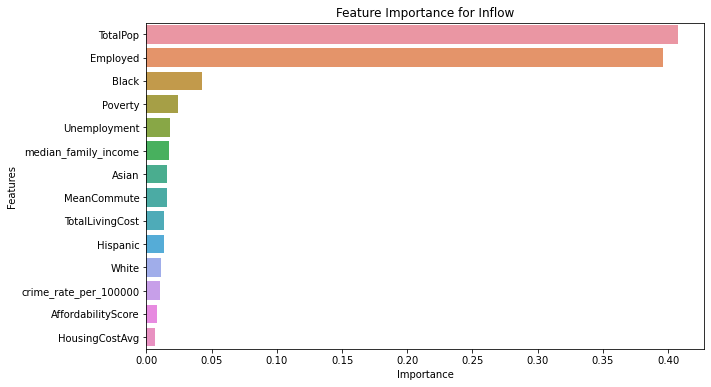

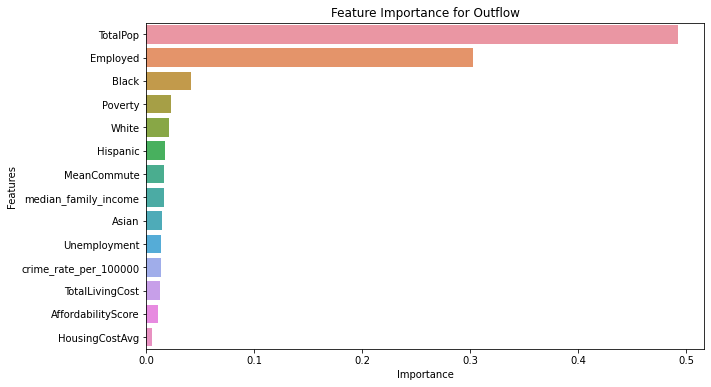

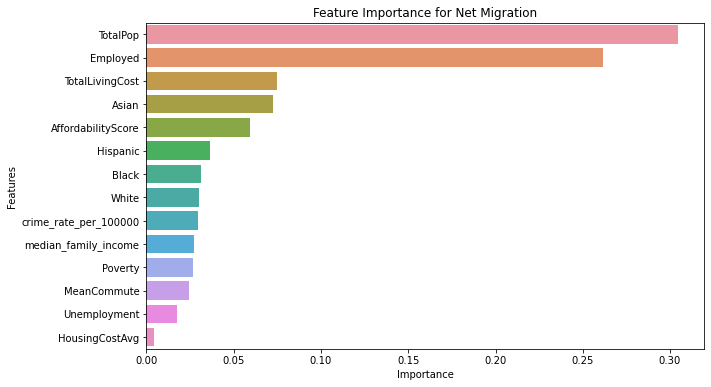

In [11]:
### plots to determine which variables influence the predictors most ###

def feature_importance(model, X, target_name):
    importance = model.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx])
    plt.title(f"Feature Importance for {target_name}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

# plot feature importance for each model
feature_importance(inflow_model, X, "Inflow")
feature_importance(outflow_model, X, "Outflow")
feature_importance(net_model, X, "Net Migration")

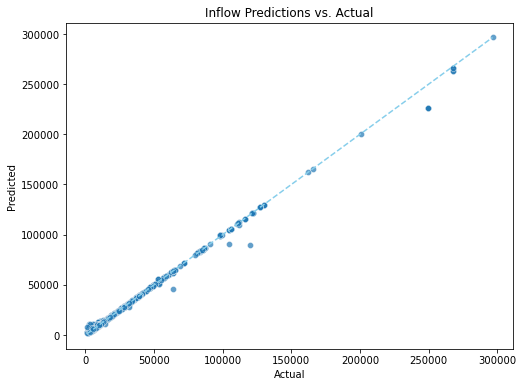

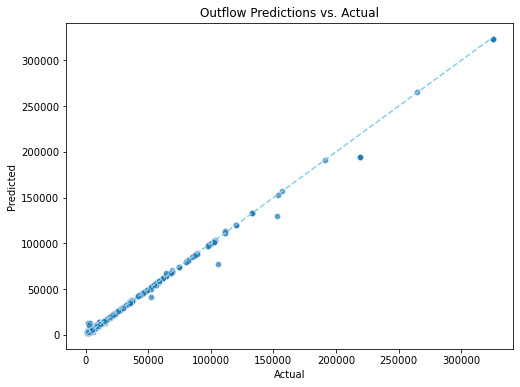

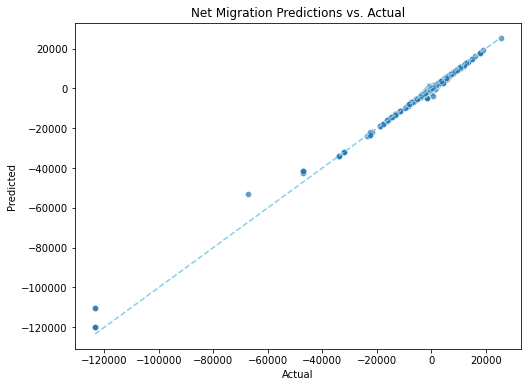

In [14]:
### compare predictions and actual values ### 

def plot_predictions(y_test, y_pred, target_name):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='skyblue', linestyle='--')
    plt.title(f"{target_name} Predictions vs. Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

# plot for inflow
X_train, X_test, y_train, y_test = train_test_split(X, y_inflow, test_size=0.2, random_state=42)
y_pred_inflow = inflow_model.predict(X_test)
plot_predictions(y_test, y_pred_inflow, "Inflow")

# plot for outflow
X_train, X_test, y_train, y_test = train_test_split(X, y_outflow, test_size=0.2, random_state=42)
y_pred_outflow = outflow_model.predict(X_test)
plot_predictions(y_test, y_pred_outflow, "Outflow")

# plot for net migration
X_train, X_test, y_train, y_test = train_test_split(X, y_net, test_size=0.2, random_state=42)
y_pred_net = net_model.predict(X_test)
plot_predictions(y_test, y_pred_net, "Net Migration")

In [22]:
### hyperparameter tuning to refine random forest ###

# define the features and target for migration prediction
features_migration = ['INflow', 'OUTflow', 'TotalPop', 'HousingCostAvg', 'median_family_income']
X_migration = affordability[features_migration]

# encode migration classes 
if 'MigrationClass' not in affordability.columns:
    affordability['MigrationClass'] = pd.cut(
        affordability['NET in'], bins=[-float('inf'), -1, 1, float('inf')], labels=["Net Loss", "Neutral", "Net Gain"]
    )
y_migration = affordability['MigrationClass']

# split data into training and testing datasets
X_train_migration, X_test_migration, y_train_migration, y_test_migration = train_test_split(
    X_migration, y_migration, test_size=0.3, random_state=42
)

# hyperparameter tuning for random forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_migration, y_train_migration)

# find best parameters and results
print("Best Parameters for MigrationClass:", grid_search.best_params_)
print("Best Accuracy Score from Grid Search:", grid_search.best_score_)

# sse the best estimator for further predictions
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_migration)
print("Classification Report for Tuned Random Forest - Migration Class:")
print(classification_report(y_test_migration, y_pred_best_rf))

Best Parameters for MigrationClass: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy Score from Grid Search: 0.7421720692459627
Classification Report for Tuned Random Forest - Migration Class:
              precision    recall  f1-score   support

    Net Gain       0.76      0.88      0.81       112
    Net Loss       0.80      0.61      0.69        83

    accuracy                           0.77       195
   macro avg       0.78      0.75      0.75       195
weighted avg       0.77      0.77      0.76       195



In [24]:
### bagging and boosting to compare with random forests ###

# bagging
bagging_migration = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_migration.fit(X_train_migration, y_train_migration)
y_pred_bag_migration = bagging_migration.predict(X_test_migration)
print("Bagging - Migration Classification Report:")
print(classification_report(y_test_migration, y_pred_bag_migration))

# boosting
boosting_migration = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
boosting_migration.fit(X_train_migration, y_train_migration)
y_pred_boost_migration = boosting_migration.predict(X_test_migration)
print("Boosting - Migration Classification Report:")
print(classification_report(y_test_migration, y_pred_boost_migration))

Bagging - Migration Classification Report:
              precision    recall  f1-score   support

    Net Gain       0.79      0.86      0.82       112
    Net Loss       0.78      0.70      0.74        83

    accuracy                           0.79       195
   macro avg       0.79      0.78      0.78       195
weighted avg       0.79      0.79      0.79       195

Boosting - Migration Classification Report:
              precision    recall  f1-score   support

    Net Gain       0.72      0.76      0.74       112
    Net Loss       0.65      0.60      0.63        83

    accuracy                           0.69       195
   macro avg       0.68      0.68      0.68       195
weighted avg       0.69      0.69      0.69       195



Unique predicted classes: ['Net Gain' 'Net Loss']
Unique true classes: ['Net Gain' 'Net Loss']


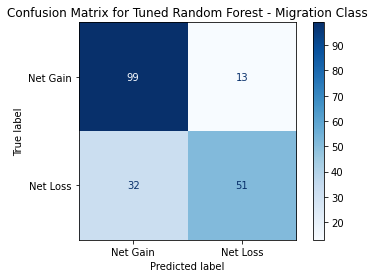

In [27]:
### classification metrics analysis ###

# ensure alignment of labels for confusion matrix
unique_labels = np.unique(y_test_migration)  
print("Unique predicted classes:", np.unique(y_pred_best_rf))
print("Unique true classes:", unique_labels)

# compute the confusion matrix with matching labels
cm = confusion_matrix(y_test_migration, y_pred_best_rf, labels=unique_labels)

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Tuned Random Forest - Migration Class")
plt.show()